In [14]:
import gym
import torch
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.multiprocessing as mp
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [15]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # 정책 (Policy π) 네트워크
        self.policy = nn.Linear(64, action_dim)

        # 가치 함수 (Value V) 네트워크
        self.value = nn.Linear(64, 1)

    def forward(self, x):
        x = self.shared_layers(x)
        policy_logits = self.policy(x)
        value = self.value(x)
        return policy_logits, value

    def select_action_2(self, state, rewards_log):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        probs = self.model(state_tensor)

        # 최근 10개의 평균 reward가 450 이상이면 best action만 선택
        if len(rewards_log) >= 10 and np.mean(rewards_log[-10:]) >= 450:
            action = torch.argmax(probs)  # 확률이 가장 높은 액션 선택
            log_prob = torch.log(probs[0, action])  # 해당 액션의 log_prob 계산
        else:
            # 기존 방식대로 확률적으로 샘플링
            distribution = torch.distributions.Categorical(probs)
            action = distribution.sample()
            log_prob = distribution.log_prob(action)

        return action.item(), log_prob  # 액션과 log 확률 반환


# 글로벌 네트워크 생성 (모든 프로세스가 공유)
def create_global_network(state_dim, action_dim):
    global_net = ActorCritic(state_dim, action_dim)
    global_net.share_memory()  # 공유 메모리 설정
    return global_net


In [16]:
class A3CWorker(mp.Process):
    def __init__(self, global_net, optimizer, env, worker_id, gamma=0.99, update_steps=5):
        super(A3CWorker, self).__init__()
        self.global_net = global_net
        self.optimizer = optimizer
        self.env = env
        self.worker_id = worker_id
        self.gamma = gamma
        self.update_steps = update_steps
        self.local_net = ActorCritic(self.env.observation_space.shape[0], self.env.action_space.n)
        self.local_net.load_state_dict(self.global_net.state_dict())  # 초기 가중치 복사
        self.reward_log = []

    def run(self):
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        log_probs = []
        values = []
        rewards = []
        total_reward = 0
        done = False

        while True:
            for _ in range(self.update_steps):
                action, log_prob = self.local_net.select_action_2(state, self.reward_log)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                values.append(self.local_net(state)[1])
                rewards.append(reward)
                total_reward += reward

                state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

                if done:
                    self.rewards_log.append(total_reward)
                    state, _ = self.env.reset()
                    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    break

            self.update_global(log_probs, values, rewards)
            log_probs.clear()
            values.clear()
            rewards.clear()

    def update_global(self, log_probs, values, rewards):
        R = 0
        returns = []
        for reward in reversed(rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns, dtype=torch.float32)
        values = torch.cat(values)
        log_probs = torch.stack(log_probs)

        # Advantage 계산
        advantages = returns - values.detach()

        # 정책 & 가치 손실 계산
        policy_loss = (-log_probs * advantages).mean()
        value_loss = F.mse_loss(values, returns)
        loss = policy_loss + value_loss

        # 글로벌 네트워크 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        for global_param, local_param in zip(self.global_net.parameters(), self.local_net.parameters()):
            global_param.grad = local_param.grad  # 글로벌 네트워크에 그래디언트 복사
        self.optimizer.step()

        # 로컬 네트워크 동기화
        self.local_net.load_state_dict(self.global_net.state_dict())




In [17]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [18]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

global_net = create_global_network(state_dim, action_dim)
global_net.apply(initialize_weights)
optimizer = optim.Adam(global_net.parameters(), lr=1e-3)

num_workers = 7  # 사용할 워커 개수 (CPU 개수만큼 생성)
workers = [A3CWorker(global_net, optimizer, env, i) for i in range(num_workers)]

[w.start() for w in workers]  # 모든 워커 시작
[w.join() for w in workers]  # 모든 워커 종료 대기

[None, None, None, None, None, None, None]

In [19]:
workers[0].reward_log

[]

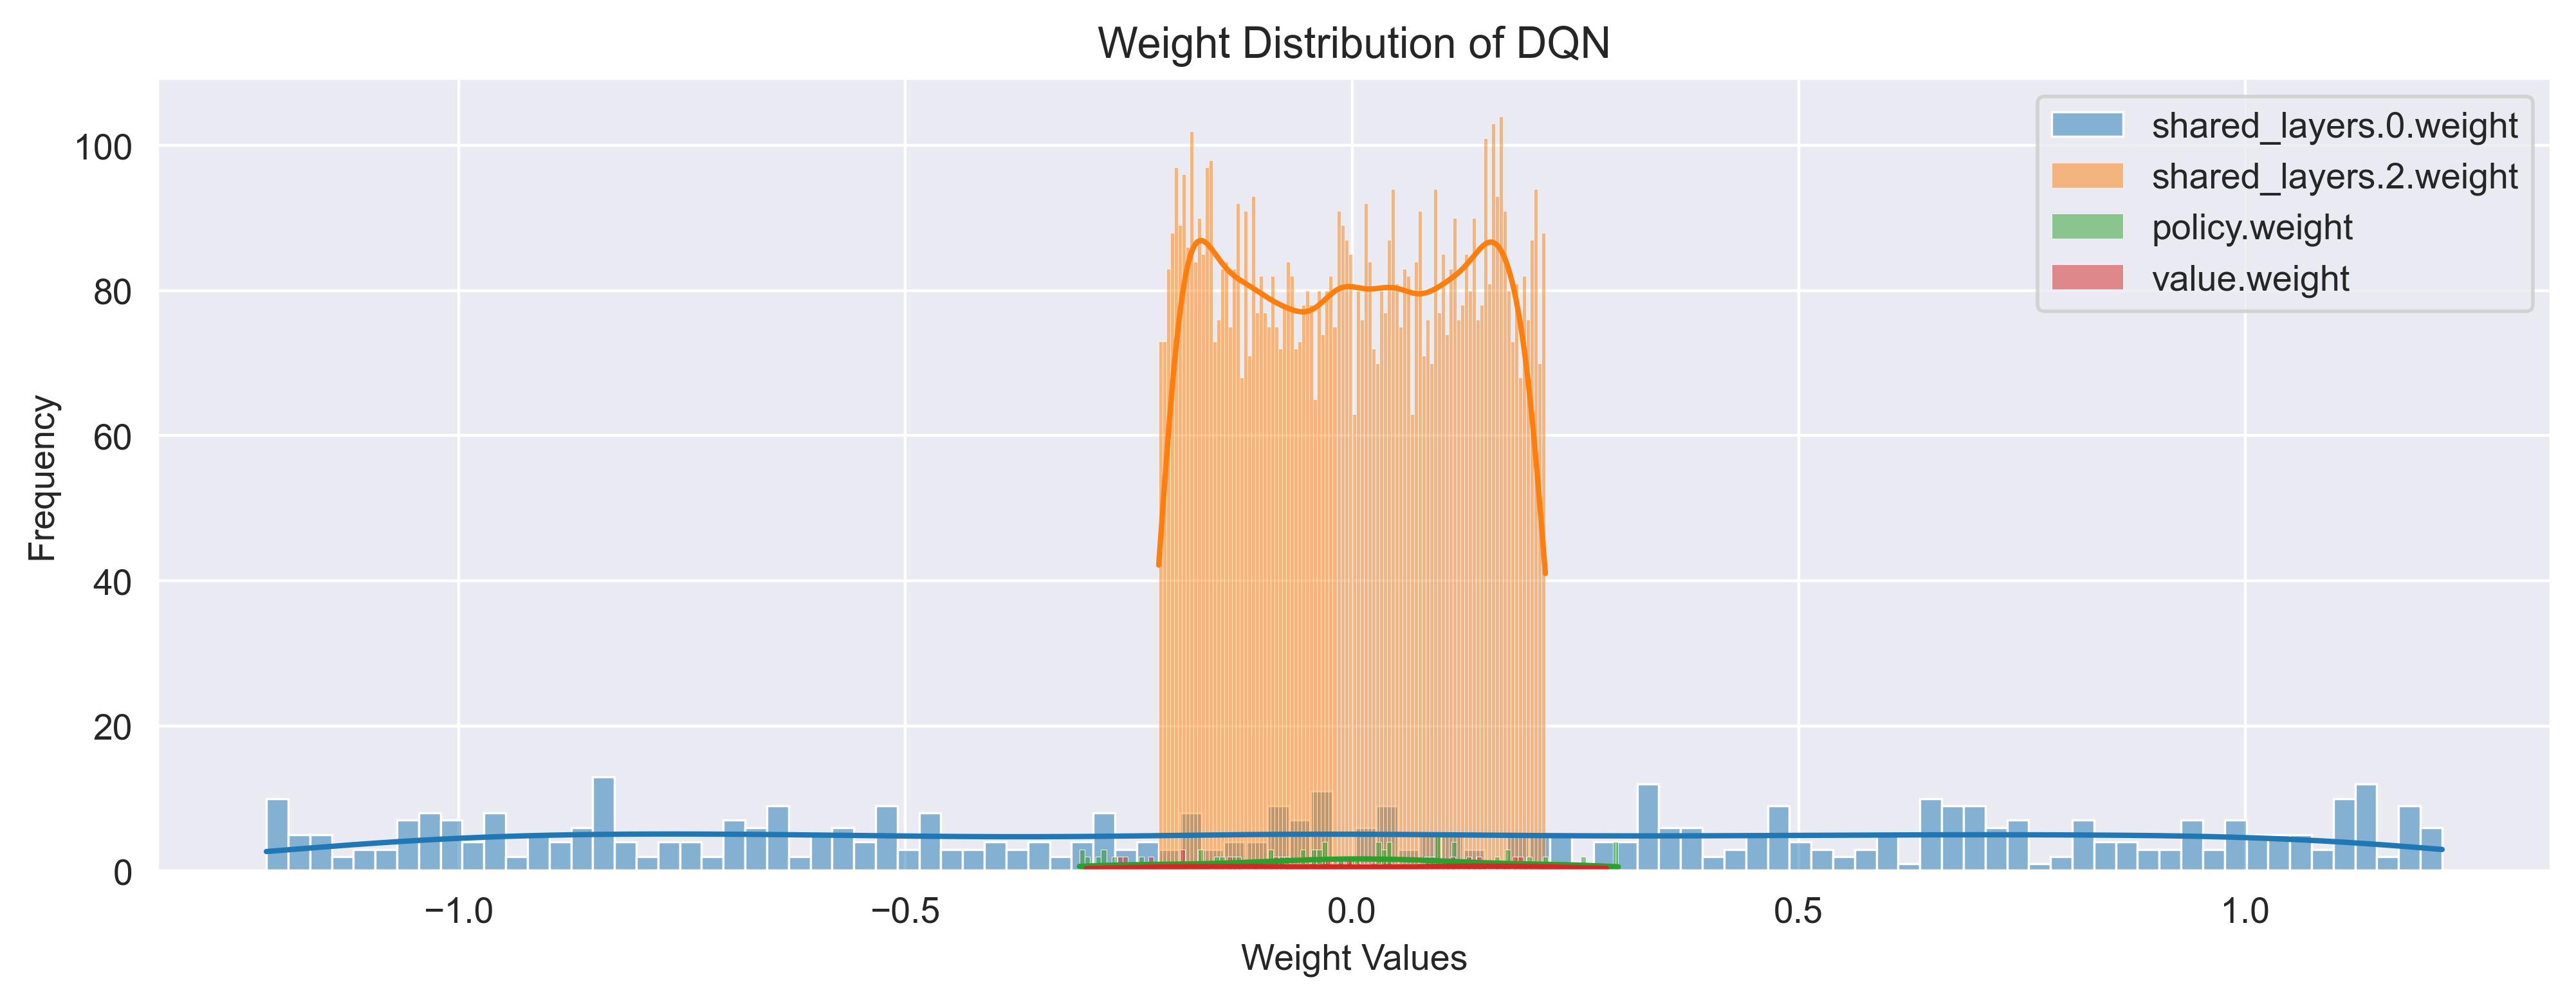

In [20]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(global_net)

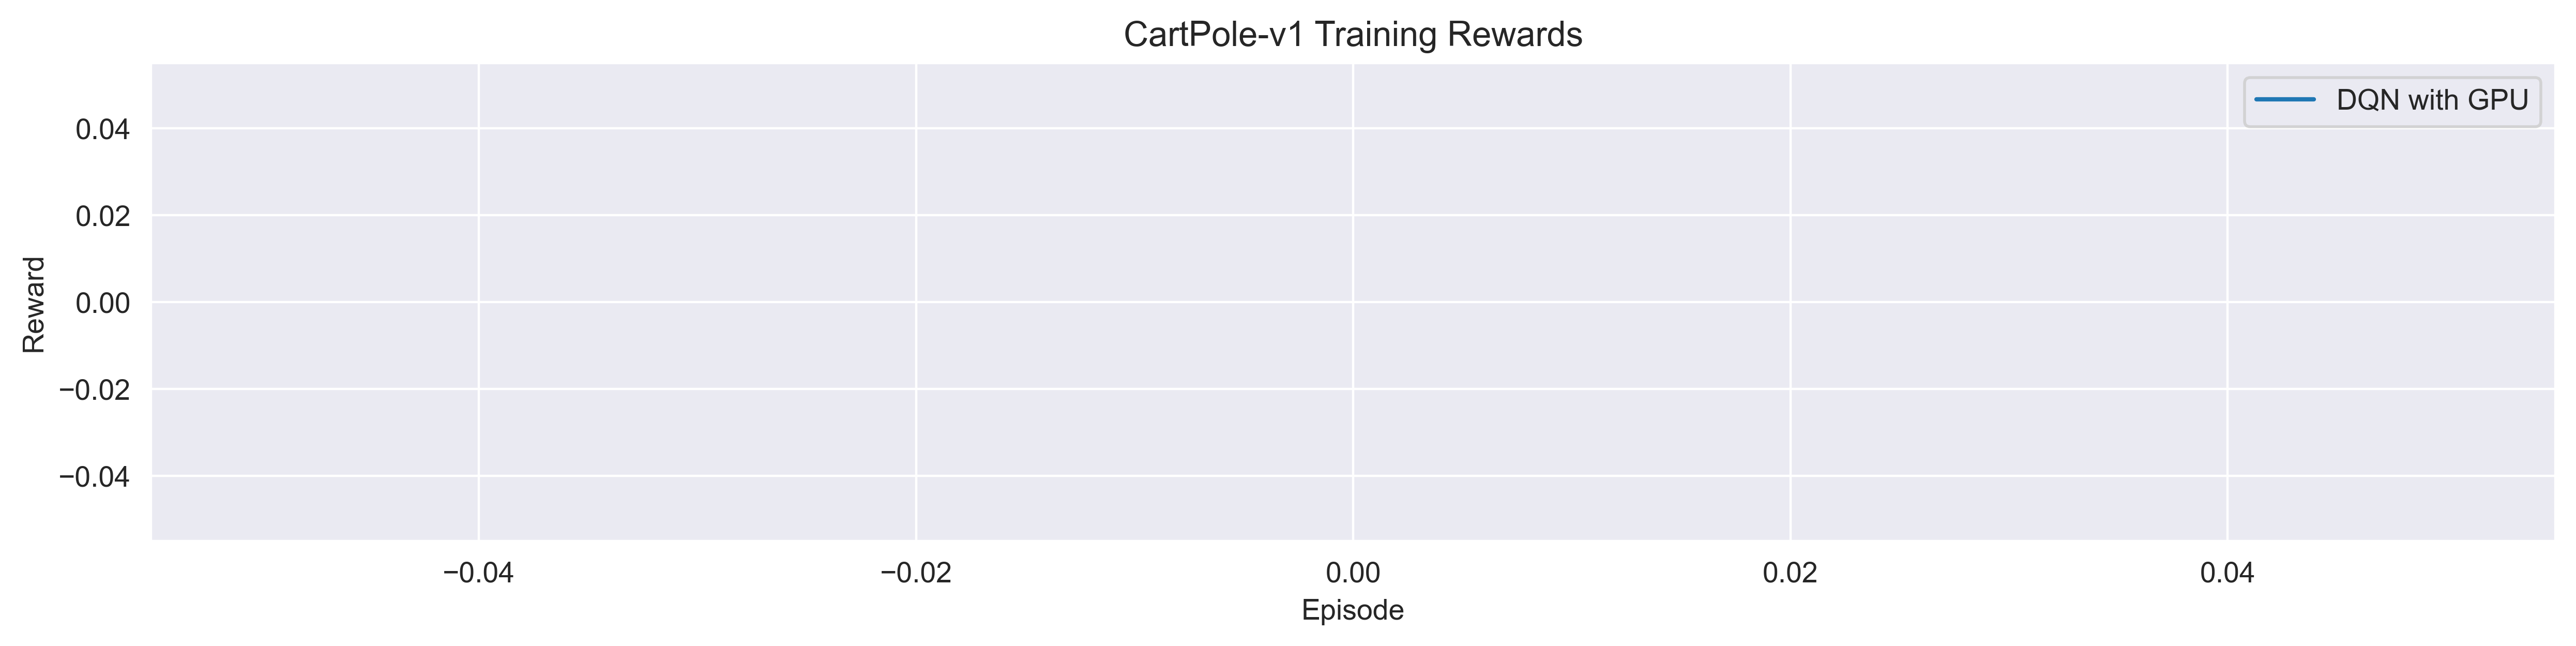

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


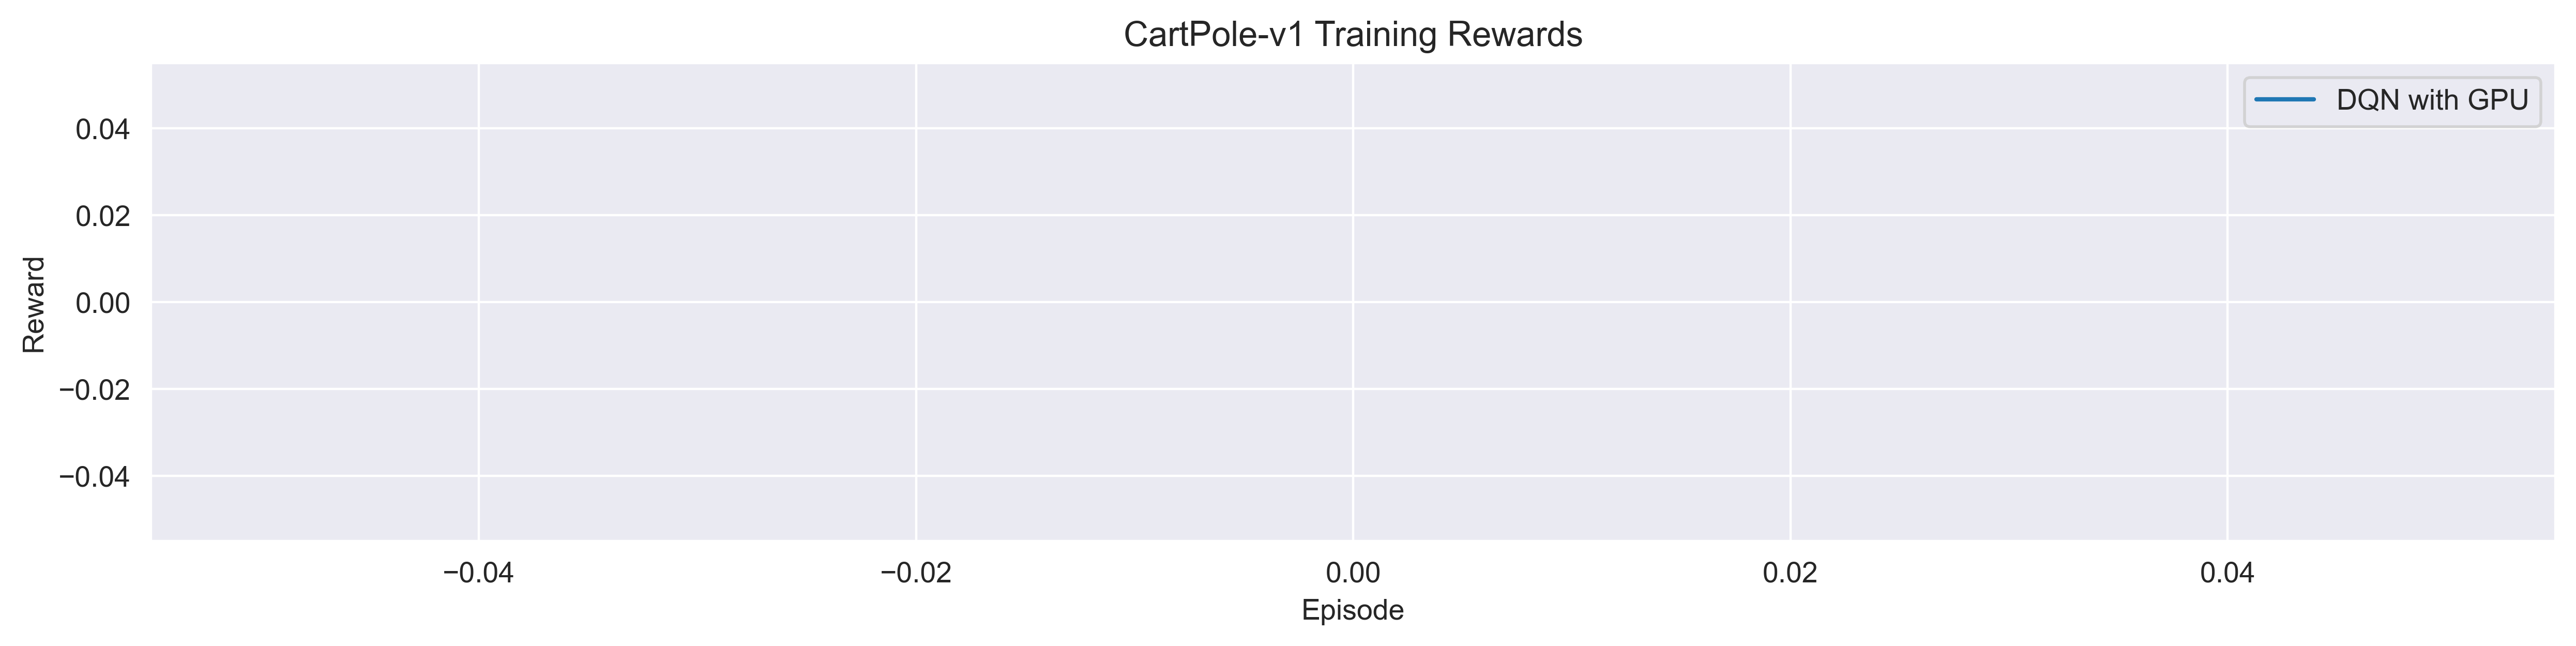

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


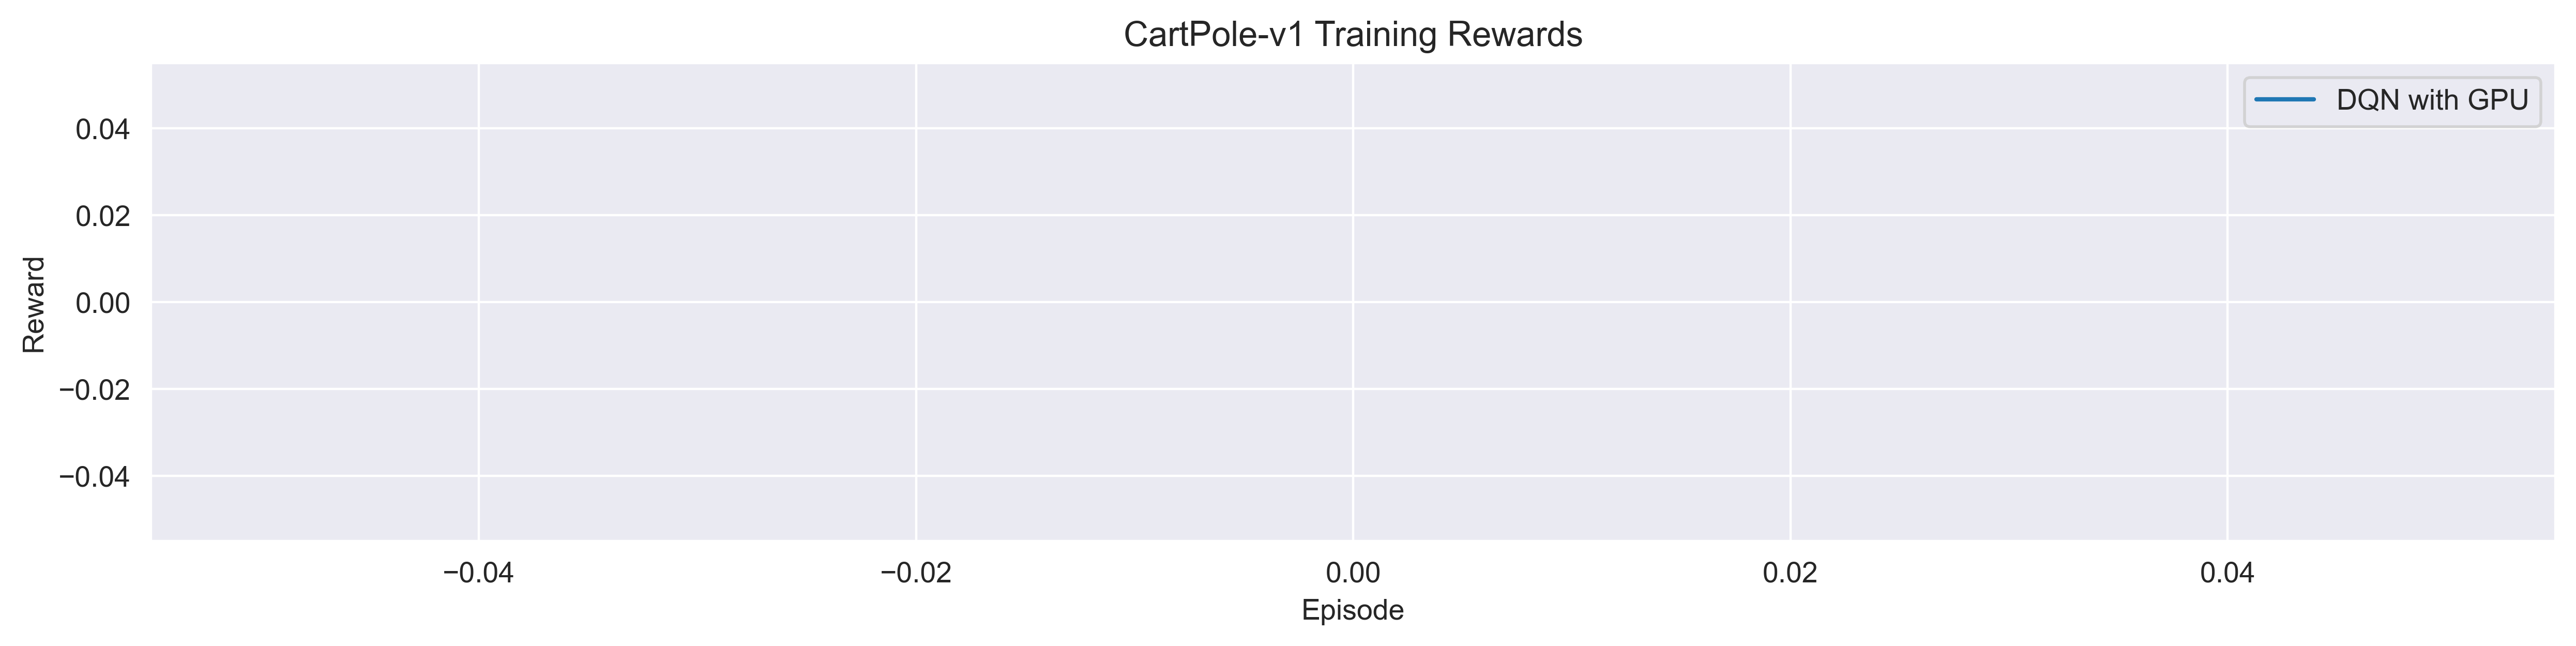

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


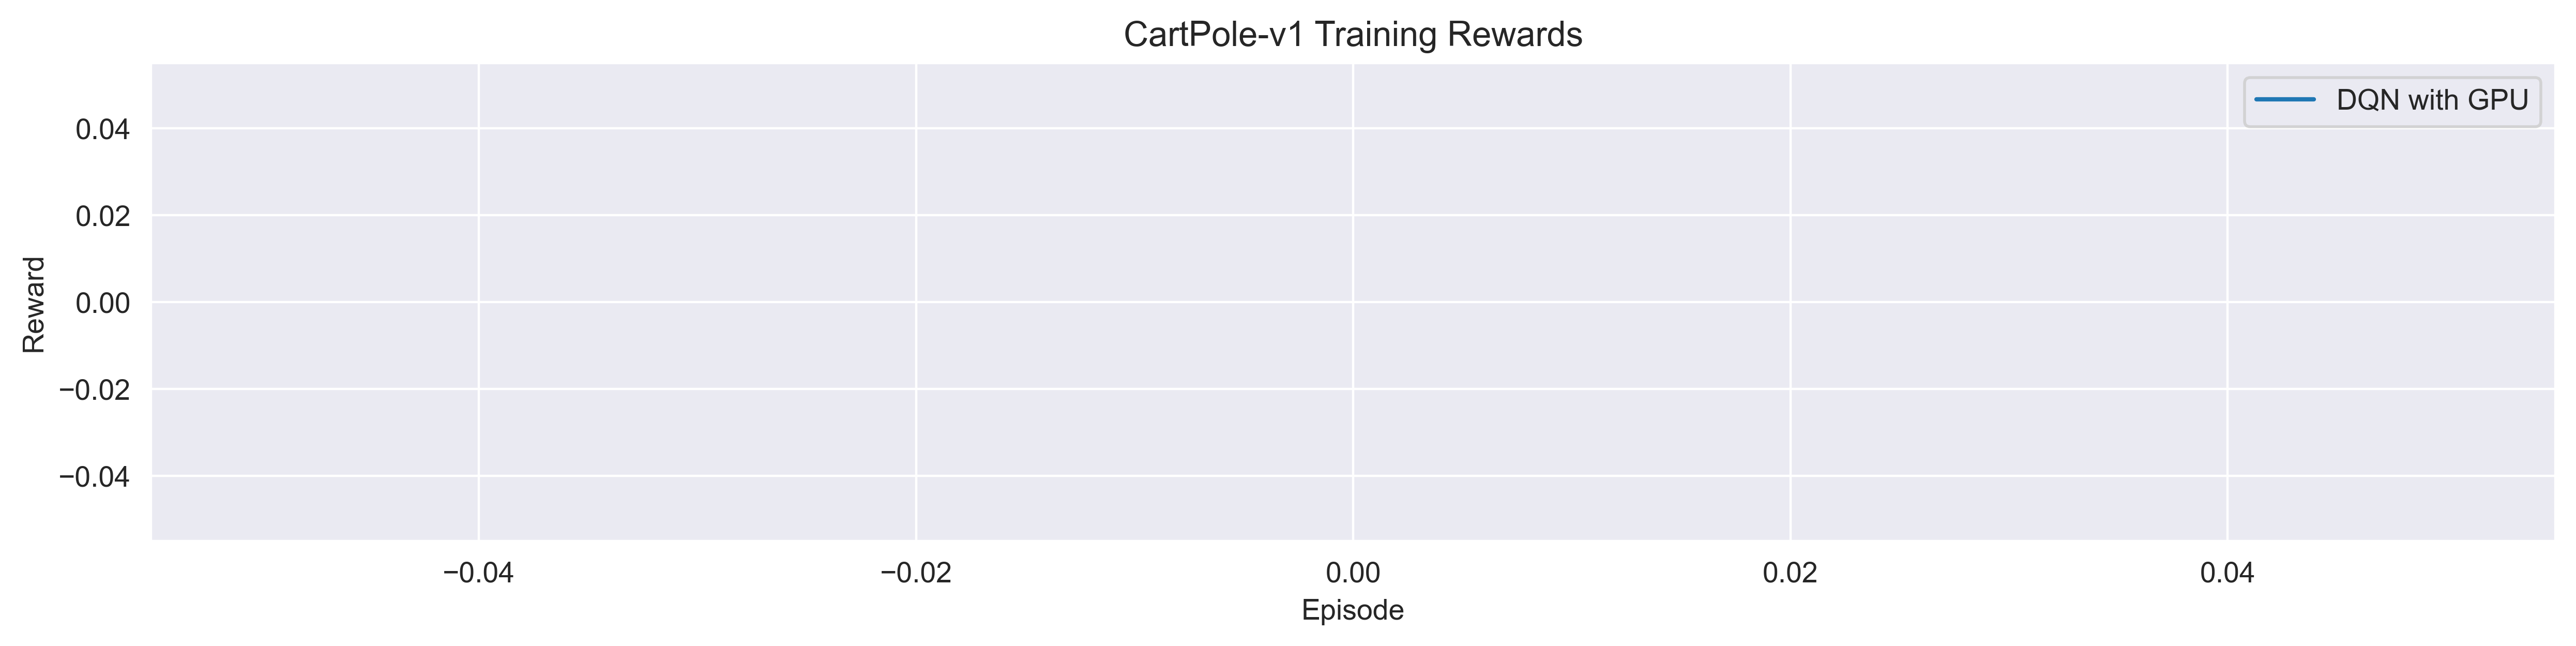

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


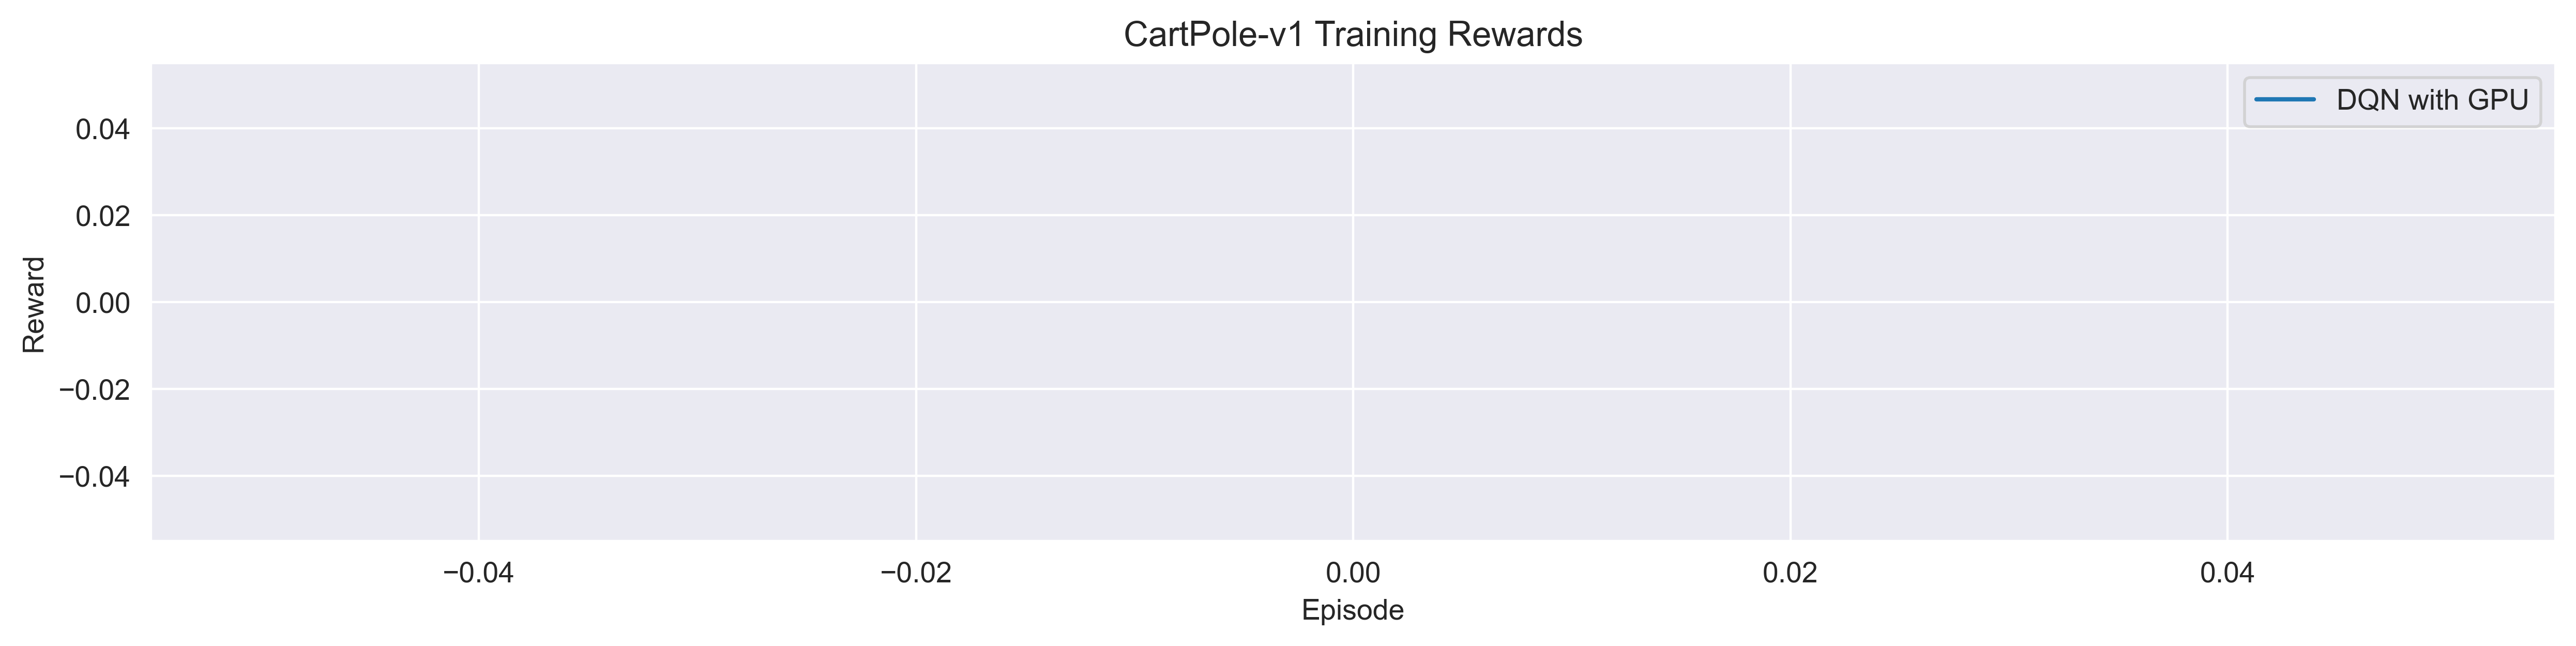

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


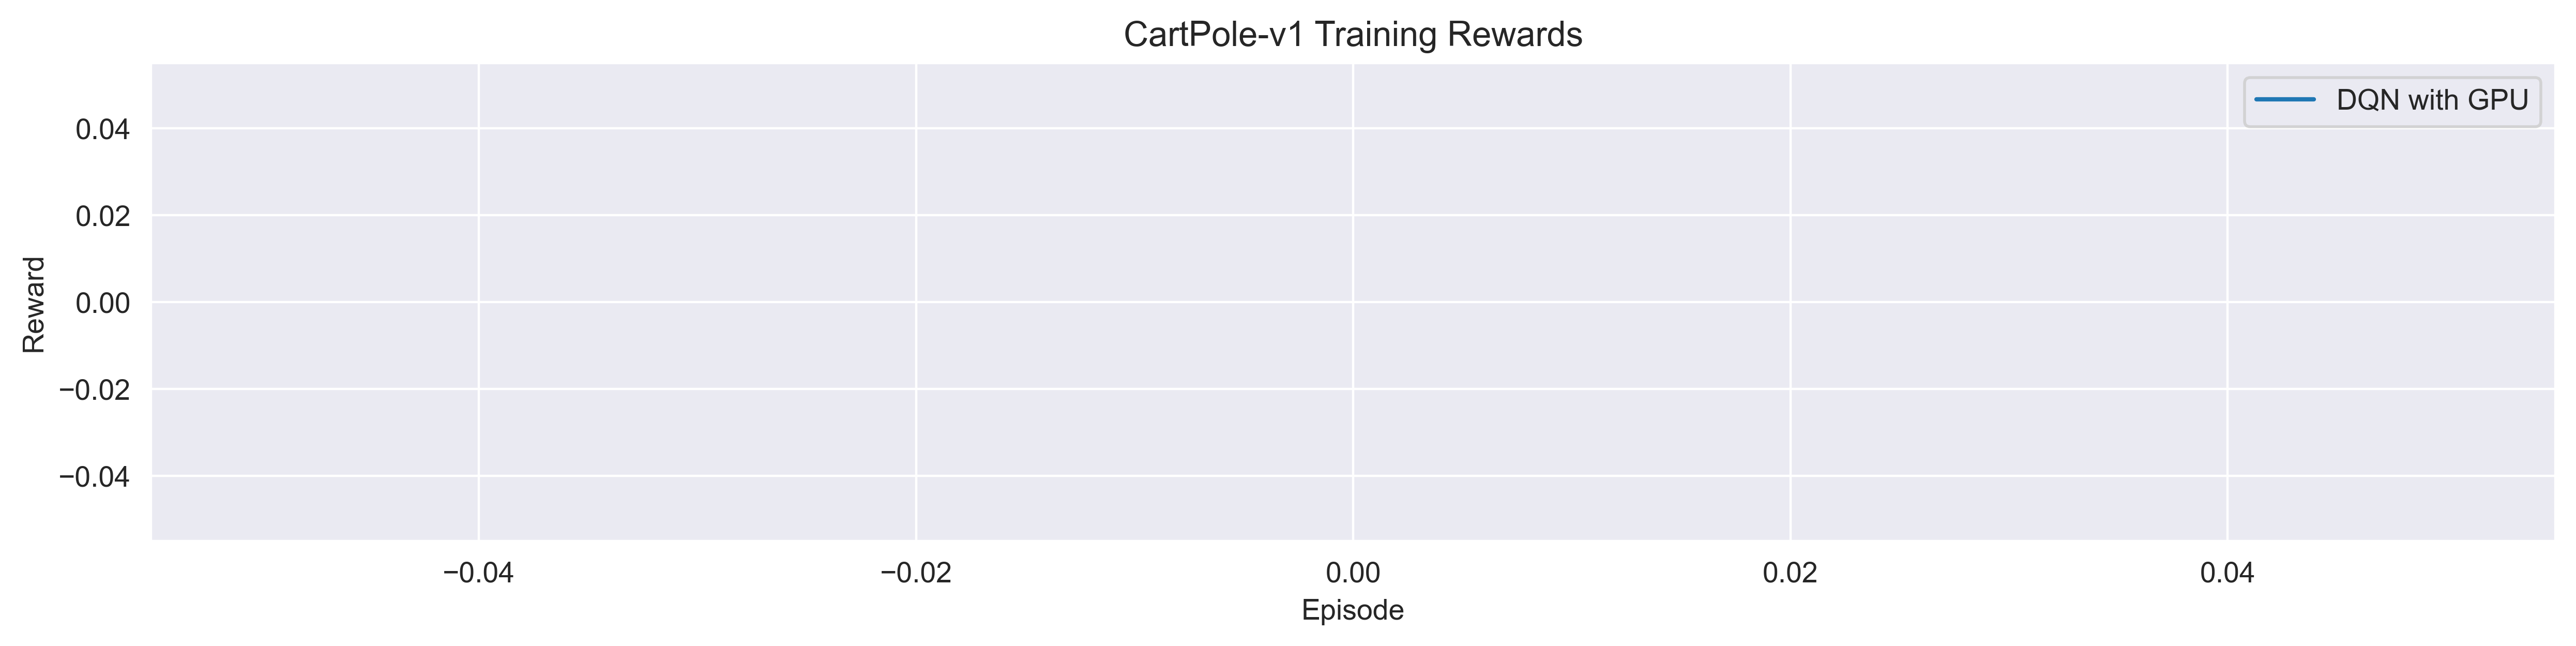

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


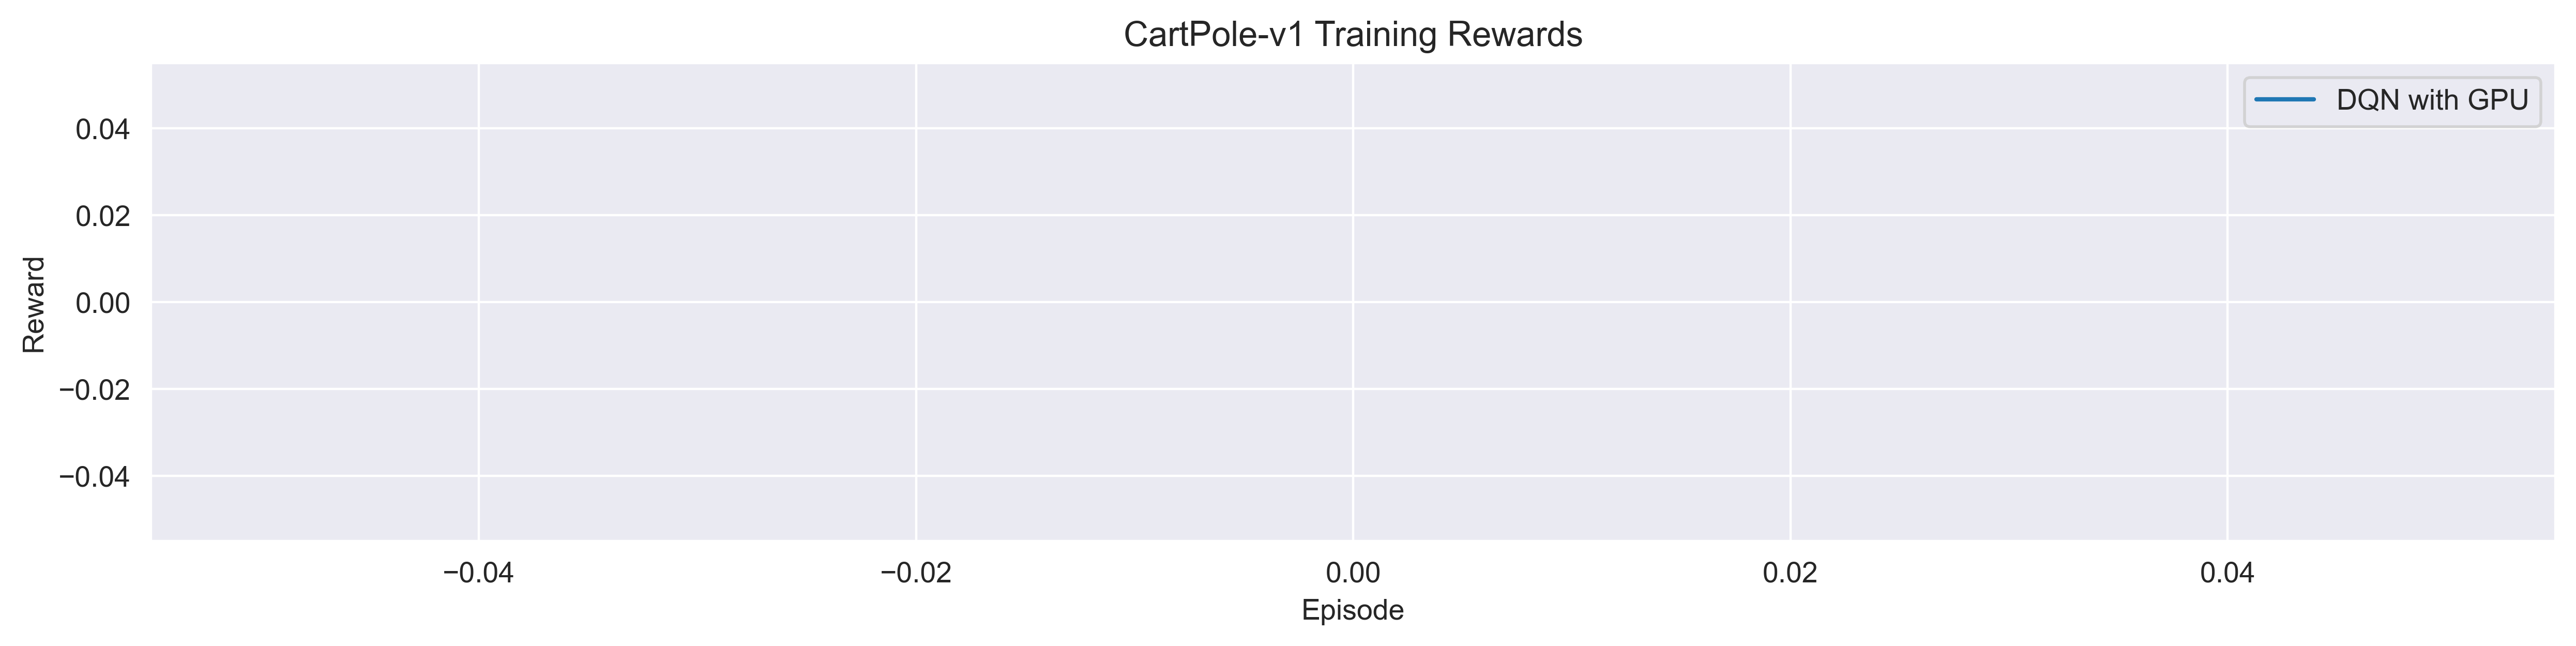

First 10 episode rewards: []
Last 10 episode rewards: []
Average reward over last 100 episodes: nan


In [22]:
# 학습 결과 시각화
for i in range(num_workers):
    plt.figure(figsize=(15, 3), dpi=400)
    plt.plot(workers[i].reward_log, label=f"Worker{i} with GPU")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("CartPole-v1 Training Rewards")
    plt.legend()
    plt.show()

    print("First 10 episode rewards:", workers[i].reward_log[:10])
    print("Last 10 episode rewards:", workers[i].reward_log[-10:])
    print(f"Average reward over last 100 episodes: {np.mean(workers[i].reward_log[-100:]):.2f}")